# Smoothing With Butterworth Filter

## Introduction
This project explores the application of the Butterworth filter for data smoothing. The objective is to demonstrate the effectiveness of the Butterworth filter in removing noise from data and enhancing signal clarity.

## Table of Contents
1. Introduction
2. Understanding the Butterworth Filter
3. Data Preparation
4. Filter Implementation
5. Results and Analysis
6. Conclusion
7. References

# Smoothing With Butterworth Filter

## **October 2023**

In our *electrical circuits and grids* course, we learnt about operational amplifiers and how to create different filters with them. While reading the book *Cycle Analytics For Traders by John F. Ehlers* I came across the concept of lag in different smoothers. The main problem is that with the conventional moving average (MA), the lag of the actual price is $ \frac{n}{2} -1 $. This basically means that we are slow with our smoothing trend and that we should be looking at other smoothers than MA if possible. Now, one of the filters we learnt about in physics class was the Butterworth filter (see image Butterworth filter). It has the nice property of not only drastically smoothing higher frequencies, but also doing it with a stupid low lag. Below, I created a lag filter with only 1.5 bars of lag. This is really nice and my first instinct was to try it out with a golden cross strategy.



This document provides a detailed mathematical description of the `super_smoother` function, which applies a smoothing filter to the input data based on the specified period.

## Function Inputs and Parameters

- `input_data`: Array or list of numerical values representing the input data to be smoothed.
- `period`: Integer value representing the period of the smoothing filter.

## Mathematical Formulation

The coefficients \( a \), \( b \), \( c1 \), \( c2 \), and \( c3 \) are calculated based on the given period:

$$ a = \exp \left( -\frac{\sqrt{2} \pi}{\text{period}} \right) $$

$$ b = 2a \cos \left( \frac{\sqrt{2} \cdot 180}{\text{period}} \right) $$

$$ c2 = b $$

$$ c3 = -a^2 $$

$$ c1 = 1 - c2 - c3 $$

An output array of the same length as `input_data` is initialized with zeros:

$$ \text{output} = \text{zeros\_like}(\text{input\_data}) $$

The super smoother filter is applied to the input data using the calculated coefficients. For $$ i \geq 2 $$:

$$ \text{output}[i] = c1 \left( \frac{\text{input\_data}[i] + \text{input\_data}[i-1]}{2} \right) + c2 \cdot \text{output}[i-1] + c3 \cdot \text{output}[i-2] $$

This recursive formula calculates each value of the output array based on the current and previous values of the input data and the previously calculated output values. The smoothed output array is then returned:

$$ \text{output} $$

## Summary of Coefficients

- $$ a = \exp \left( -\frac{\sqrt{2} \pi}{\text{period}} \right) $$
- $$ b = 2a \cos \left( \frac{\sqrt{2} \cdot 180}{\text{period}} \right) $$
- $$ c1 = 1 - b + a^2 $$
- $$ c2 = b $$
- $$ c3 = -a^2 $$



The filter is then applied to the `input_data` to produce the smoothed `output`. Lag from each parameter $ \frac{|c1| + 2 *|c2| + 3 *|c3|}{|c1| + |c2| + |c3|} = 7/4$




[*********************100%%**********************]  1 of 1 completed


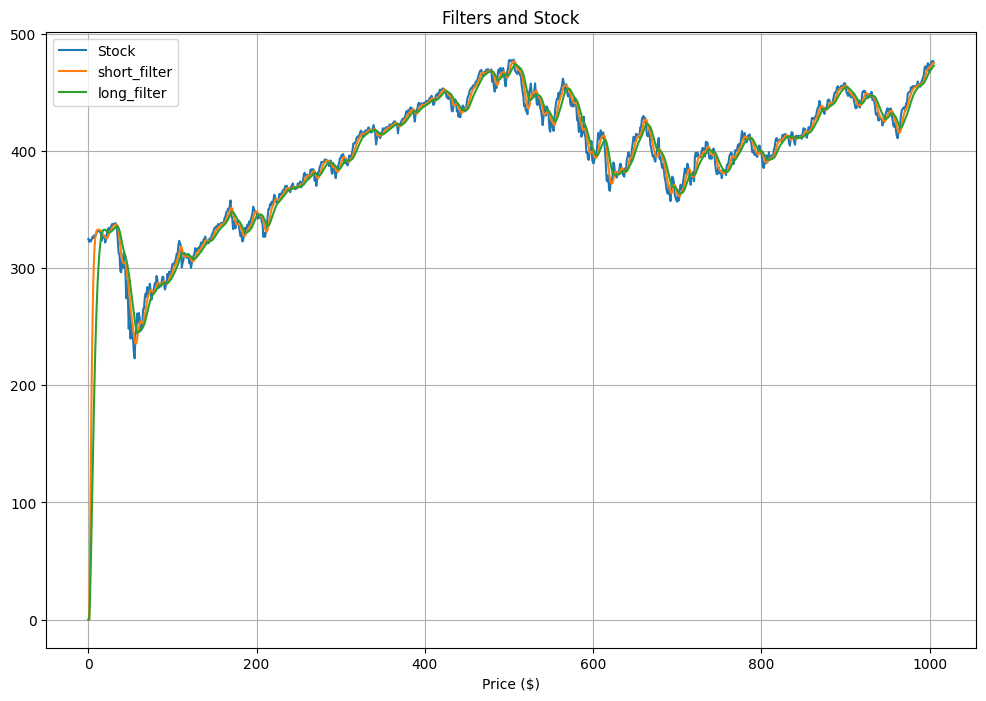

<ipython-input-3-3249c3253916>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_df['Trade'] = np.where(trades_df['GoldenCross'], 'Buy', 'Sell')
<ipython-input-3-3249c3253916>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_df['EntryExitPrice'] = trades_df['Close']


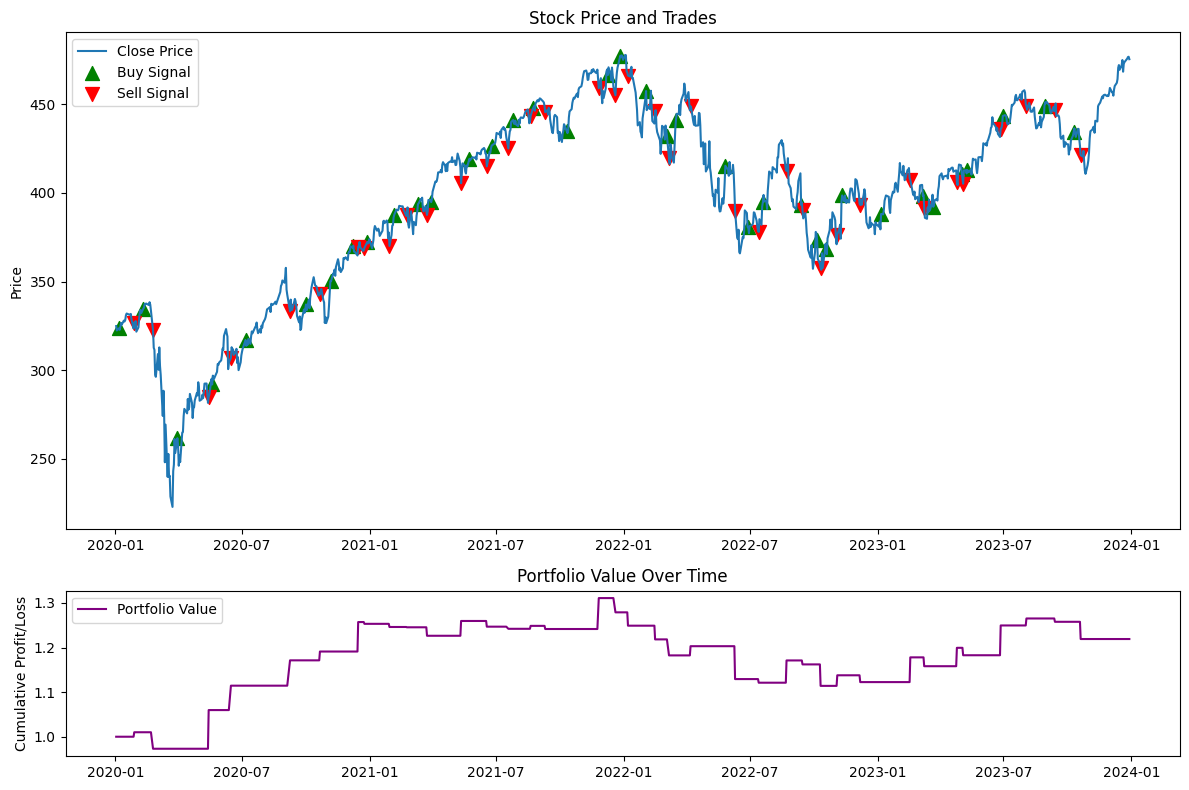

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def get_stock_data(stock,startdate,enddate,period,interval):
        ticker = stock
        yf.pdr_override()
        df = yf.download(tickers=stock, start=startdate, end=enddate, interval=interval,period=period)
        df.reset_index(inplace=True)
        df['date'] = df['Date'].dt.date

        return df

def super_smoother(input_data, period):
    a = np.exp(-np.sqrt(2) * np.pi / period)
    b = 2 * a * np.cos(np.sqrt(2) * 180 / period)
    c2 = b
    c3 = -a**2
    c1 = 1 - c2 - c3

    output = np.zeros_like(input_data)
    for i in range(2, len(input_data)):
        output[i] = c1 * (input_data[i] + input_data[i-1]) / 2 + c2 * output[i-1] + c3 * output[i-2]

    return output

def golden_cross(input_data, short_period, long_period):
    # Apply the SuperSmoother filter with two different periods
    short_filter = super_smoother(input_data, short_period)
    long_filter = super_smoother(input_data, long_period)

    # Initialize golden cross points
    golden_cross_points = []

    # Identifying the Golden Cross
    for i in range(1, len(input_data)):
        if short_filter[i] > long_filter[i] and short_filter[i-1] <= long_filter[i-1]:
            golden_cross_points.append(i)

    return golden_cross_points


def backtest_strategy(stock_data, golden_cross_points, short_period, long_period):
    # Apply the SuperSmoother filter with two different periods
    short_filter = super_smoother(stock_data['Close'].values, short_period)
    long_filter = super_smoother(stock_data['Close'].values, long_period)
    fig = plt.figure(figsize=[12,8])
    plt.plot(stock_data.Close,label='Stock')
    plt.plot(short_filter,label='short_filter')
    plt.plot(long_filter,label='long_filter')
    plt.title('Filters and Stock')
    plt.xlabel('Time (t)')
    plt.xlabel('Price ($)')
    plt.grid()
    plt.legend()
    plt.show()

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'Close': stock_data['Close'],
        'ShortFilter': short_filter,
        'LongFilter': long_filter
    })

    # Identify Golden Cross and Reverse Cross (sell signal)
    df['GoldenCross'] = (df['ShortFilter'] > df['LongFilter']) & (df['ShortFilter'].shift(1) <= df['LongFilter'].shift(1))
    df['ReverseCross'] = (df['ShortFilter'] < df['LongFilter']) & (df['ShortFilter'].shift(1) >= df['LongFilter'].shift(1))

    # Filter rows where a trade would occur
    trades_df = df[df['GoldenCross'] | df['ReverseCross']]

    # Calculate profits
    trades_df['Trade'] = np.where(trades_df['GoldenCross'], 'Buy', 'Sell')

    trades_df['EntryExitPrice'] = trades_df['Close']
    buy_prices = trades_df[trades_df['Trade'] == 'Buy']['EntryExitPrice']
    sell_prices = trades_df[trades_df['Trade'] == 'Sell']['EntryExitPrice']
    #print(len(sell_prices))
    #print(len(buy_prices))
    if len(sell_prices)>len(buy_prices):
        sell_prices = sell_prices.iloc[:-1]
    if len(buy_prices)>len(sell_prices):
        buy_prices = buy_prices.iloc[:-1]
    #print(sell_prices.values)
    #print(buy_prices.values)
    profits = sell_prices.values / buy_prices.values

    # Compile trade details
    trade_details = list(zip(buy_prices, sell_prices))[:len(profits)]
    #print(profits)
    #print(profits.cumsum())
    # Calculate overall performance
    total_profit = profits.cumprod()
    total_trades = len(trade_details)
    profit_per_trade = total_profit / total_trades if total_trades > 0 else 0

    return {
        "Total Profit": total_profit,
        "Total Trades": total_trades,
        "Average Profit per Trade": profit_per_trade,
        "Trades": trade_details
    }


def plot_trading_strategy(stock_data, trade_results):
    # Extract trade details
    trades = trade_results['Trades']
    total_profit = trade_results['Total Profit']

    # Prepare DataFrame for plotting
    df = stock_data.copy()
    df['TradeSignal'] = None
    df['PortfolioValue'] = 0

    # Mark trade entries and exits
    for buy_price, sell_price in trades:
        buy_index = df[df['Close'] == buy_price].index[0]
        sell_index = df[df['Close'] == sell_price].index[0]
        df.at[buy_index, 'TradeSignal'] = 'Buy'
        df.at[sell_index, 'TradeSignal'] = 'Sell'

        # Update Portfolio Value
        df.at[sell_index, 'PortfolioValue'] = (sell_price / buy_price)


    # Cumulative sum of portfolio values
    #print(df.PortfolioValue)
    df['PortfolioValue'] = np.where(df['PortfolioValue']<0.1,1, df['PortfolioValue'])
    df['PortfolioValue'] = df['PortfolioValue'].cumprod()
    #print(df.PortfolioValue)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Plot stock close price
    ax[0].plot(df['Date'], df['Close'], label='Close Price')
    ax[0].scatter(df[df['TradeSignal'] == 'Buy']['Date'], df[df['TradeSignal'] == 'Buy']['Close'],
                  label='Buy Signal', marker='^', color='green', s=100)
    ax[0].scatter(df[df['TradeSignal'] == 'Sell']['Date'], df[df['TradeSignal'] == 'Sell']['Close'],
                  label='Sell Signal', marker='v', color='red', s=100)
    ax[0].set_title('Stock Price and Trades')
    ax[0].set_ylabel('Price')
    ax[0].legend()

    # Plot portfolio value
    ax[1].plot(df['Date'], df['PortfolioValue'], label='Portfolio Value', color='purple')
    ax[1].set_title('Portfolio Value Over Time')
    ax[1].set_ylabel('Cumulative Profit/Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()



stock_data = get_stock_data('SPY', '2020-01-01', '2024-01-01', None, '1d')
golden_cross_pts = golden_cross(stock_data['Close'].values, 10, 20)
result = backtest_strategy(stock_data, golden_cross_pts, 10, 20)
plot_trading_strategy(stock_data, result)
#print(result)

